# MF의 최적 파라미터 찾기 

- 최적의 K와 Iterations를 찾는 에를 살표 본다. 현재 K와 iteration가 얼마가 최적인지 알 수 없으므로 아래와 같은 절차로 최적값을 찾아보자
    1. 최적의 K가 대략 어떤 수인지 확인하기 위해 50부터 260까지 넓은 범위 대해서 10 간격으로 정확도 (RMSE)를 계산
    2. 최적의 RMSE를 보이는 k를 확인한 후 이 숫자 전후 10의 K에 대해서 1의 간격으로 다시 한번 RSME를 계산해서 최적의 K값을 찾는다 
    3. iteration는 학습과정에서 충분히 큰 숫자르 ㄹ주어서 RMSE가 어떻게 변화하는지 관찰해서 주어진 K에 대해서 최적의 Iteration 값을 구한다 
    

In [1]:
import numpy as np
import pandas as pd

from sklearn.utils import shuffle

In [2]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [3]:
# train test 분리
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [6]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])


    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)



##### 최적의 K와 iteration 수를 결정

In [7]:
# 최적의 K값 찾기
results = []
index = []
for K in range(50, 261, 10): # K를 50에서 260까지 10 간격으로 반복
    print('K =', K) 
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0) # full matirx
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True) 
    test_set = mf.set_test(ratings_test) 
    result = mf.test() # 주어진 K값에 따라 iteration 1~300까지 정확도 계산 
    index.append(K)
    results.append(result)


K = 50
Iteration: 10 ; Train RMSE = 0.9661 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9414 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9240 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9197 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9163 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9133 ; Test RMSE = 0.9466
Iteration: 80 ; Train RMSE = 0.9102 ; Test RMSE = 0.9454
Iteration: 90 ; Train RMSE = 0.9066 ; Test RMSE = 0.9443
Iteration: 100 ; Train RMSE = 0.9020 ; Test RMSE = 0.9430
Iteration: 110 ; Train RMSE = 0.8958 ; Test RMSE = 0.9412
Iteration: 120 ; Train RMSE = 0.8875 ; Test RMSE = 0.9387
Iteration: 130 ; Train RMSE = 0.8767 ; Test RMSE = 0.9356
Iteration: 140 ; Train RMSE = 0.8634 ; Test RMSE = 0.9320
Iteration: 150 ; Train RMSE = 0.8481 ; Test RMSE = 0.9283
Iteration: 160 ; Train RMSE = 0.8312 ; Test RMSE = 0.9250
Iteration: 170 ; Train RMSE = 0.8130 ; Test RMSE = 0.9222
Iteration: 180 ;

Iteration: 230 ; Train RMSE = 0.7135 ; Test RMSE = 0.9119
Iteration: 240 ; Train RMSE = 0.6899 ; Test RMSE = 0.9122
Iteration: 250 ; Train RMSE = 0.6662 ; Test RMSE = 0.9132
Iteration: 260 ; Train RMSE = 0.6426 ; Test RMSE = 0.9146
Iteration: 270 ; Train RMSE = 0.6194 ; Test RMSE = 0.9165
Iteration: 280 ; Train RMSE = 0.5967 ; Test RMSE = 0.9187
Iteration: 290 ; Train RMSE = 0.5748 ; Test RMSE = 0.9211
Iteration: 300 ; Train RMSE = 0.5537 ; Test RMSE = 0.9237
K = 100
Iteration: 10 ; Train RMSE = 0.9663 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9418 ; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9310 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9249 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9208 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9179 ; Test RMSE = 0.9480
Iteration: 70 ; Train RMSE = 0.9155 ; Test RMSE = 0.9467
Iteration: 80 ; Train RMSE = 0.9133 ; Test RMSE = 0.9457
Iteration: 90 ; Train RMSE = 0.9109 ; Test RMSE = 0.9448
Iteration: 100 

Iteration: 150 ; Train RMSE = 0.8779 ; Test RMSE = 0.9321
Iteration: 160 ; Train RMSE = 0.8659 ; Test RMSE = 0.9283
Iteration: 170 ; Train RMSE = 0.8525 ; Test RMSE = 0.9246
Iteration: 180 ; Train RMSE = 0.8377 ; Test RMSE = 0.9213
Iteration: 190 ; Train RMSE = 0.8213 ; Test RMSE = 0.9183
Iteration: 200 ; Train RMSE = 0.8033 ; Test RMSE = 0.9156
Iteration: 210 ; Train RMSE = 0.7836 ; Test RMSE = 0.9133
Iteration: 220 ; Train RMSE = 0.7625 ; Test RMSE = 0.9116
Iteration: 230 ; Train RMSE = 0.7400 ; Test RMSE = 0.9105
Iteration: 240 ; Train RMSE = 0.7167 ; Test RMSE = 0.9100
Iteration: 250 ; Train RMSE = 0.6927 ; Test RMSE = 0.9101
Iteration: 260 ; Train RMSE = 0.6685 ; Test RMSE = 0.9108
Iteration: 270 ; Train RMSE = 0.6443 ; Test RMSE = 0.9120
Iteration: 280 ; Train RMSE = 0.6204 ; Test RMSE = 0.9135
Iteration: 290 ; Train RMSE = 0.5970 ; Test RMSE = 0.9153
Iteration: 300 ; Train RMSE = 0.5742 ; Test RMSE = 0.9173
K = 150
Iteration: 10 ; Train RMSE = 0.9664 ; Test RMSE = 0.9834
Iterati

Iteration: 70 ; Train RMSE = 0.9165 ; Test RMSE = 0.9468
Iteration: 80 ; Train RMSE = 0.9147 ; Test RMSE = 0.9459
Iteration: 90 ; Train RMSE = 0.9129 ; Test RMSE = 0.9451
Iteration: 100 ; Train RMSE = 0.9110 ; Test RMSE = 0.9443
Iteration: 110 ; Train RMSE = 0.9086 ; Test RMSE = 0.9434
Iteration: 120 ; Train RMSE = 0.9053 ; Test RMSE = 0.9422
Iteration: 130 ; Train RMSE = 0.9006 ; Test RMSE = 0.9404
Iteration: 140 ; Train RMSE = 0.8940 ; Test RMSE = 0.9379
Iteration: 150 ; Train RMSE = 0.8852 ; Test RMSE = 0.9346
Iteration: 160 ; Train RMSE = 0.8743 ; Test RMSE = 0.9308
Iteration: 170 ; Train RMSE = 0.8617 ; Test RMSE = 0.9270
Iteration: 180 ; Train RMSE = 0.8478 ; Test RMSE = 0.9234
Iteration: 190 ; Train RMSE = 0.8326 ; Test RMSE = 0.9201
Iteration: 200 ; Train RMSE = 0.8159 ; Test RMSE = 0.9171
Iteration: 210 ; Train RMSE = 0.7976 ; Test RMSE = 0.9145
Iteration: 220 ; Train RMSE = 0.7778 ; Test RMSE = 0.9124
Iteration: 230 ; Train RMSE = 0.7566 ; Test RMSE = 0.9108
Iteration: 240 ; 

Iteration: 290 ; Train RMSE = 0.6253 ; Test RMSE = 0.9121
Iteration: 300 ; Train RMSE = 0.6017 ; Test RMSE = 0.9136
K = 240
Iteration: 10 ; Train RMSE = 0.9664 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9420 ; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9314 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9253 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9215 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9188 ; Test RMSE = 0.9480
Iteration: 70 ; Train RMSE = 0.9167 ; Test RMSE = 0.9468
Iteration: 80 ; Train RMSE = 0.9150 ; Test RMSE = 0.9459
Iteration: 90 ; Train RMSE = 0.9134 ; Test RMSE = 0.9452
Iteration: 100 ; Train RMSE = 0.9117 ; Test RMSE = 0.9444
Iteration: 110 ; Train RMSE = 0.9096 ; Test RMSE = 0.9436
Iteration: 120 ; Train RMSE = 0.9068 ; Test RMSE = 0.9425
Iteration: 130 ; Train RMSE = 0.9029 ; Test RMSE = 0.9410
Iteration: 140 ; Train RMSE = 0.8972 ; Test RMSE = 0.9387
Iteration: 150 ; Train RMSE = 0.8895 ; Test RMSE = 0.9357
Iteration: 160 

In [8]:
# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)): # 각 K 값에 대해서 아래의 코드를 실행해서 최고의 iteration 값을 확인 
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

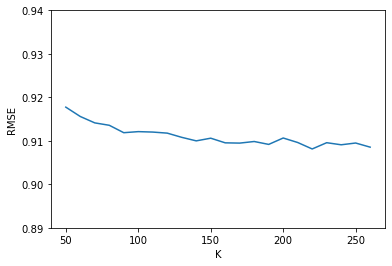

In [9]:
# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

- 숫자로 보면 K=240 부근에서 가장 좋은 결과이지만 K=200 이후로는 사실상 큰 변화가 없다는 것을 확인할 수 있다. 크래서 K=200을 최적의 K로 간주한다. 그리고 대략 Iterations =250 정도에서 최적의 결과를 보여줌을 알 수 잇다 . 

# MF와 SVD
- MF와 SVD(Singular Value Decomposition), 둘다 데이터 분석과 기계학습에 널리 사용되고 유사한 점이 있지만 명백히 다른 기법이다. 
- SVD는 3개 행렬로 분해서 이를 학습시키고 이 3개의 행렬로 원래 행렬을 재현(re-creation)하는 기법이다. 
- 그에 비해 MF에서는 원래 데이터를 P(M x K)와 Q(N x K), 2개의 행렬로 분해한다는 점에서 차이가 있다 